In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

all_df = pd.read_csv('TrainDataset2024.csv', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

In [5]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutliers(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = func(x)
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

removeOutliers(all_df)
# Verify the changes
all_df.head()

# Assign features to X
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

1. Feature 10 (0.018317)
2. Feature 39 (0.015674)
3. Feature 109 (0.015486)
4. Feature 107 (0.015441)
5. Feature 29 (0.014874)
6. Feature 11 (0.014450)
7. Feature 12 (0.014091)
8. Feature 0 (0.014020)
9. Feature 106 (0.013711)
10. Feature 108 (0.013315)
11. Feature 37 (0.013233)
12. Feature 69 (0.012923)
13. Feature 16 (0.012128)
14. Feature 36 (0.012004)
15. Feature 90 (0.011822)
16. Feature 21 (0.011524)
17. Feature 32 (0.011514)
18. Feature 104 (0.011359)
19. Feature 27 (0.011213)
20. Feature 26 (0.011167)
21. Feature 38 (0.011114)
22. Feature 110 (0.011095)
23. Feature 33 (0.010821)
24. Feature 31 (0.010772)
25. Feature 95 (0.010581)
26. Feature 40 (0.010433)
27. Feature 17 (0.010431)
28. Feature 15 (0.010307)
29. Feature 68 (0.010244)
30. Feature 92 (0.010170)
31. Feature 91 (0.010120)
32. Feature 30 (0.010039)
33. Feature 14 (0.009996)
34. Feature 70 (0.009962)
35. Feature 42 (0.009760)
36. Feature 34 (0.009739)
37. Feature 3 (0.009524)
38. Feature 85 (0.009455)
39. Feature 93 (0

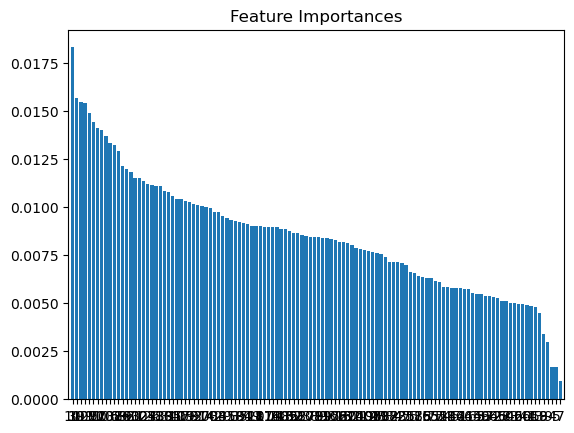

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Normalise the features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [1,3,10]
required_features = Xs[:, mandatory_features_indices]

rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rnd_clf.fit(Xs, clf_y)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(Xs.shape[1]):
    print("%d. Feature %d (%f)" % (i + 1, indices[i], importances[indices[i]]))

plt.title('Feature Importances')
plt.bar(range(Xs.shape[1]), importances[indices], align='center')
plt.xticks(range(Xs.shape[1]), indices)
plt.xlim([-1, Xs.shape[1]])
plt.show()

Xs_selected = Xs[:, indices[:50]]

# Apply LDA to all except required features
lda = LinearDiscriminantAnalysis(n_components=1)
Xs_lda = lda.fit_transform(Xs_selected, clf_y)

# Combine required features with LDA transformed features
Xs = np.hstack((required_features, Xs_lda))

In [14]:
from numpy import mean, std
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=1)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

Accuracy: 0.790 (0.050)
Best Model: RandomForestClassifier(max_features=4, random_state=1)


In [15]:
from sklearn.linear_model import LogisticRegression

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = LogisticRegression(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

Accuracy: 0.825 (0.032)
Best Model: LogisticRegression(C=1, random_state=1)


In [16]:
from sklearn.model_selection import train_test_split

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, clf_y, test_size=0.3,
random_state=1, stratify=clf_y)

from sklearn.svm import SVC

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = SVC(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.01, 0.1]
space['kernel'] = ["rbf", "linear", "poly"]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs_train, y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs_train, y_train)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

from sklearn.metrics import accuracy_score

classifier_score = best_model.score(Xs_test, y_test)
print('The classifier accuracy score is {:03.2f}'.format(classifier_score))

Accuracy: 0.825 (0.061)
Best Model: SVC(C=1, gamma=0.1, random_state=1)
The classifier accuracy score is 0.79


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
import numpy as np

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=2)

# USING PCA for only the MRI data
Xs_pca = pca.fit_transform(Xs[:, 11:])
Xs = np.hstack((Xs[:, :11], Xs_pca))

from sklearn.feature_selection import SelectKBest, f_classif


mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [X.columns.get_loc(feature) for feature in mandatory_features]

#feature selection to pick top k features using ANOVA F-statistic
k = 10 
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(Xs, clf_y) 

selected_indices = selector.get_support(indices=True)
selected_feature_names = [X.columns[i] for i in selected_indices]

#union of mandatory and selected features, so mandatory features are included
final_selected_indices = list(set(selected_indices).union(mandatory_features_indices))
final_selected_feature_names = [X.columns[i] for i in final_selected_indices]

Xs = X.iloc[:, final_selected_indices]

In [18]:
from sklearn.svm import SVC

# configure the cross-validation procedure
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
model = SVC(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.01, 0.1]
space['kernel'] = ["rbf", "linear", "poly"]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=5, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)


Accuracy: 0.772 (0.044)
Best Model: SVC(C=0.1, gamma=0.01, random_state=1)
